In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

def perform_svd(attention_matrix):
    """
    Perform Singular Value Decomposition (SVD) on an attention matrix.

    Parameters:
    - attention_matrix: A 2D numpy array representing the attention matrix.

    Returns:
    - U: Left singular vectors.
    - S: Singular values.
    - Vh: Right singular vectors (conjugate transposed).
    """
    U, S, Vh = np.linalg.svd(attention_matrix, full_matrices=True)
    return U, S, Vh

def calculate_mle_gaussian(weights):
    """
    Calculate the MLE for a multivariate Gaussian distribution describing the weight matrix.

    Parameters:
    - weights: A numpy array of shape (n_observations, n_features) representing the weight matrix.

    Returns:
    - mean_vector: The mean vector of the Gaussian distribution.
    - covariance_matrix: The covariance matrix of the Gaussian distribution.
    """
    # Calculate the mean vector
    mean_vector = np.mean(weights, axis=0)
    
    # Calculate the covariance matrix
    covariance_matrix = np.cov(weights, rowvar=False)
    
    return mean_vector, covariance_matrix


def calculate_eigenvalues(matrix):
    """
    Calculate the eigenvalues of a square matrix.

    Parameters:
    - matrix: A square numpy array representing the matrix.

    Returns:
    - eigenvalues: A numpy array containing the eigenvalues of the matrix.
    """
    eigenvalues, _ = np.linalg.eig(matrix)
    return eigenvalues

def gaussian_entropy(cov_P, regularization_term=1e-6):
    """
    Calculate the entropy of a multivariate normal distribution.

    Parameters:
    - cov_P: Covariance matrix of the multivariate normal distribution.

    Returns:
    - Entropy of the multivariate normal distribution.
    """
    d = cov_P.shape[0]  # Dimension of the Gaussian distributions
    regularization_term=1e-6
    regularization_matrix = np.eye(d) * regularization_term
    cov_P = cov_P + regularization_matrix
    det_cov_P = np.linalg.det(cov_P)  # Determinant of the covariance matrix
    eig_P, _ = np.linalg.eig(cov_P)
    entropy = 0.5 * (d + np.log(2 * np.pi)) + 0.5 *  np.log(det_cov_P)
    return entropy

def gaussian_cross_entropy(mean_P, cov_P, mean_Q, cov_Q, regularization_term=1e-6):
    """
    Calculate the KL divergence (as a proxy for cross entropy component) between two multivariate Gaussian distributions P and Q.

    Parameters:
    - mean_P: Mean vector of the first Gaussian distribution P.
    - cov_P: Covariance matrix of the first Gaussian distribution P.
    - mean_Q: Mean vector of the second Gaussian distribution Q.
    - cov_Q: Covariance matrix of the second Gaussian distribution Q.

    Returns:
    - kl_divergence: The KL divergence between P and Q.
    """
    d = mean_P.shape[0]  # Dimension of the Gaussian distributions
    regularization_term=1e-6
    regularization_matrix = np.eye(d) * regularization_term
    cov_P = cov_P + regularization_matrix
    cov_Q = cov_Q + regularization_matrix
    eig_P, _ = np.linalg.eig(cov_P)
    eig_Q, _ = np.linalg.eig(cov_Q)
    fraction = 1.0
    for eigp, eigq in zip(eig_P, eig_Q):
        fraction *= eigp / eigq
    fraction = fraction.real
    term1 = np.log(fraction) / 2
    term2 = np.trace(np.linalg.inv(cov_Q) @ cov_P) / 2
    term3 = ((mean_Q - mean_P).T @ np.linalg.inv(cov_Q) @ (mean_Q - mean_P)) / 2
    term4 = -d / 2
    cross_entropy = term1 + term2 + term3 + term4
    return cross_entropy

def gaussian_kl_divergence(mean_P, cov_P, mean_Q, cov_Q, regularization_term=1e-6):
    """
    Calculate the KL divergence between two multivariate Gaussian distributions P and Q.

    Parameters:
    - mean_P: Mean vector of the first Gaussian distribution P.
    - cov_P: Covariance matrix of the first Gaussian distribution P.
    - mean_Q: Mean vector of the second Gaussian distribution Q.
    - cov_Q: Covariance matrix of the second Gaussian distribution Q.

    Returns:
    - kl_divergence: The KL divergence between P and Q.
    """
    cross_entropy = gaussian_cross_entropy(mean_P, cov_P, mean_Q, cov_Q, regularization_term)
    entropy = gaussian_entropy(cov_P, regularization_term)
    kl_divergence = cross_entropy - entropy
    return kl_divergence

def gaussian_js_divergence(mean_P, cov_P, mean_Q, cov_Q, regularization_term=1e-6):
    """Approximate the Jensen-Shannon divergence between two multivariate Gaussians."""
    kl_pq = gaussian_kl_divergence(mean_P, cov_P, mean_Q, cov_Q, regularization_term)
    kl_qp = gaussian_kl_divergence(mean_Q, cov_Q, mean_P, cov_P, regularization_term)
    return 0.5 * (kl_pq + kl_qp)


def mutual_information(sigma_X, sigma_Y, sigma_XY=None):

    if sigma_XY is None:
        sigma_XY = calculate_cross_covariance(sigma_X, sigma_Y)
    # Calculate the determinants of the covariance matrices
    det_sigma_X = np.linalg.det(sigma_X)
    det_sigma_Y = np.linalg.det(sigma_Y)
    
    # Construct the joint covariance matrix
    sigma_YX = sigma_XY.T
    sigma_XY_joint = np.block([[sigma_X, sigma_XY], [sigma_YX, sigma_Y]])
    det_sigma_XY_joint = np.linalg.det(sigma_XY_joint)
    
    # Calculate the mutual information
    MI = 0.5 * np.log((det_sigma_X * det_sigma_Y) / det_sigma_XY_joint)
    return MI


def calculate_cross_covariance(X, Y):
    n = X.shape[0]  # Number of samples
    
    # Calculate the mean of X and Y
    mean_X = np.mean(X, axis=0)
    mean_Y = np.mean(Y, axis=0)
    
    # Calculate the deviations from the mean for X and Y
    X_dev = X - mean_X
    Y_dev = Y - mean_Y
    
    # Calculate the cross-covariance matrix
    sigma_XY = (X_dev.T @ Y_dev) / (n - 1)
    
    return sigma_XY


def calculate_kl_divergence_between_layers(attention, regularization_term=1e-6):
    num_layers = len(attention)
    mean_vectors, covariance_matrices, svds = [], [], []
    for attention_layer in attention:
        average_attention_head = torch.mean(attention_layer[0], 0).detach().numpy()
        mean_vector, covariance_matrix = calculate_mle_gaussian(average_attention_head)
        u, S, vh = perform_svd(covariance_matrix)
        mean_vectors.append(mean_vector)
        covariance_matrices.append(covariance_matrix)
        svds.append(S)

    cross_attention_matrix = np.zeros((num_layers, num_layers)).astype(np.float32)

    for i in range(num_layers):
        for j in range(num_layers):
            if i != j:
                cross_attention_matrix[i][j] = gaussian_kl_divergence(mean_vectors[i], covariance_matrices[i], mean_vectors[j], covariance_matrices[j], regularization_term)
    
    return cross_attention_matrix



def calculate_kl_divergence_between_heads(attention, regularization_term=1e-6):

    num_layers, num_heads = len(attention), len(attention[0][0])
    mean_vectors, covariance_matrices, svds = [], [], []

    for layer in attention:
        mean_vectors_layer, covariance_matrices_layer, svds_layer = [], [], []
        for head in layer[0]:
            mean_vector, covariance_matrix = calculate_mle_gaussian(head.detach().numpy())
            u, S, vh = perform_svd(covariance_matrix)
            mean_vectors_layer.append(mean_vector)
            covariance_matrices_layer.append(covariance_matrix)
            svds_layer.append(S)
        mean_vectors.append(mean_vectors_layer)
        covariance_matrices.append(covariance_matrices_layer)
        svds.append(svds_layer)

    cross_attention_matrix = np.zeros((num_layers, num_heads, num_heads)).astype(np.float32)

    for i in range(num_layers):
        for j in range(num_heads):
            for k in range(num_heads):
                if j != k:
                    cross_attention_matrix[i][j][k] = gaussian_kl_divergence(mean_vectors[i][j], covariance_matrices[i][j], mean_vectors[i][k], covariance_matrices[i][k], regularization_term)
    
    return cross_attention_matrix



def plot_mean_attention_layers(attention):
    for layer in range(len(attention)):
        plt.figure(figsize=(6, 6))
        mean_attention_img = torch.mean(attention[layer][0], dim=0).detach().numpy()
        plt.imshow(mean_attention_img.transpose(), cmap='viridis', aspect='equal', alpha=0.6)
        plt.title('Attention scores of layer {} of the mean transformer block'.format(layer))
        plt.show()

def plot_singular_value_spectrum(singular_values, title='Singular Value Spectrum'):
    """
    Plot the singular value spectrum of a matrix.

    Parameters:
    - vector: A NumPy array, containng all the singular values.
    """
    
    # Plot the singular values
    plt.figure(figsize=(6, 3))
    plt.plot(singular_values, marker='o')
    plt.title(title)
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value Magnitude')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.yscale('log')  # Optional: Use a log scale for better visibility if values vary widely
    plt.show()

def plot_matrix_with_matplotlib(matrix, title='KL Divergence Scores', xlabel='Attention Head', ylabel='Attention Head'):
        plt.figure(figsize=(5, 5))
        plt.imshow(matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(range(matrix.shape[1]))
        plt.yticks(range(matrix.shape[0]))
        plt.show()


def plot_kl_divergence_scores_between_heads(cross_attention_matrix):
    for i in range(len(cross_attention_matrix)):
        plot_matrix_with_matplotlib(np.log(cross_attention_matrix[i]), title=f"KL Divergence Scores for layer {i}", xlabel="Attention Head", ylabel="Attention Head")
    
def plot_kl_divergence_scores_between_layers(cross_attention_matrix):
    plot_matrix_with_matplotlib(np.log(cross_attention_matrix), title="KL Divergence Scores", xlabel="Layer", ylabel="Layer")


In [9]:
import torch
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

print(torch.cuda.is_available())

True


In [10]:
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [11]:
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [12]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

C:\Users\marti\AppData\Local\Temp\ipykernel_13628\797895484.py:256: RuntimeWarning: divide by zero encountered in log
  plot_matrix_with_matplotlib(np.log(cross_attention_matrix[i]), title=f"KL Divergence Scores for layer {i}", xlabel="Attention Head", ylabel="Attention Head")


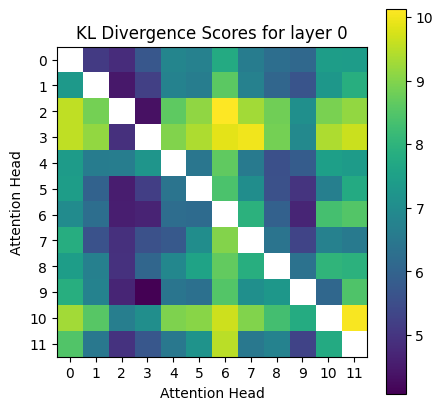

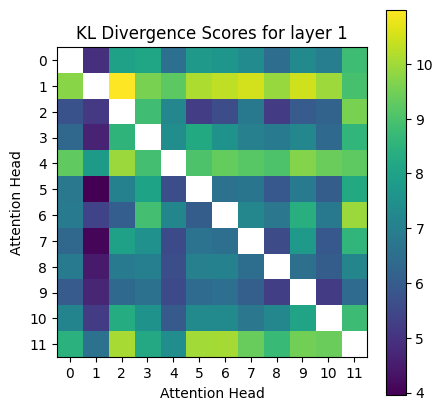

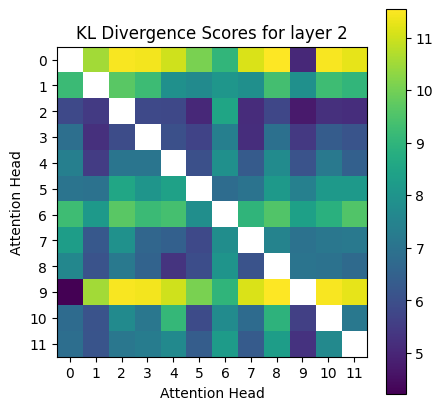

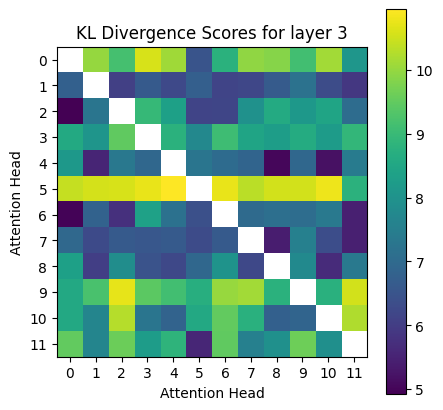

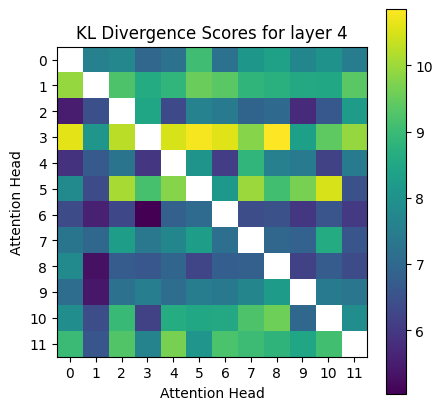

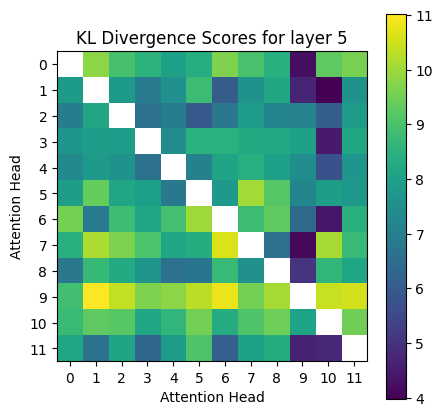

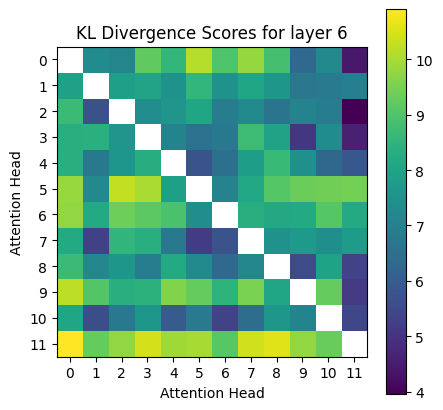

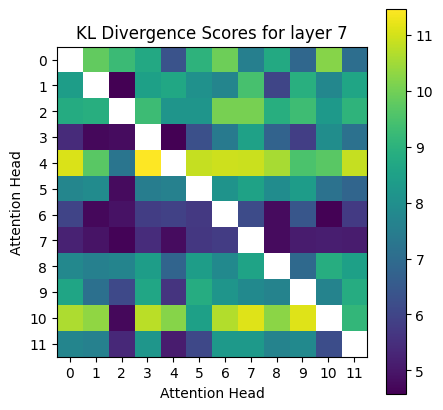

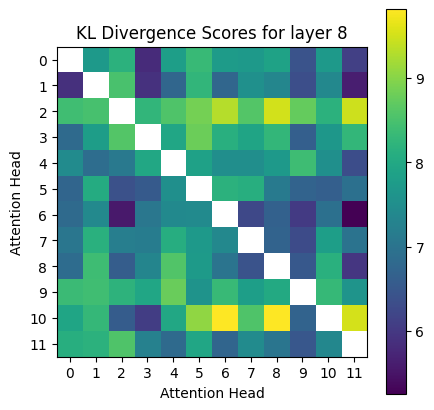

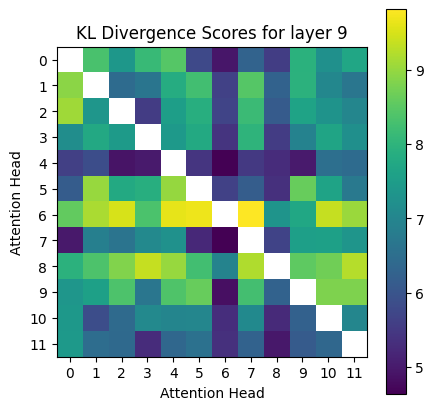

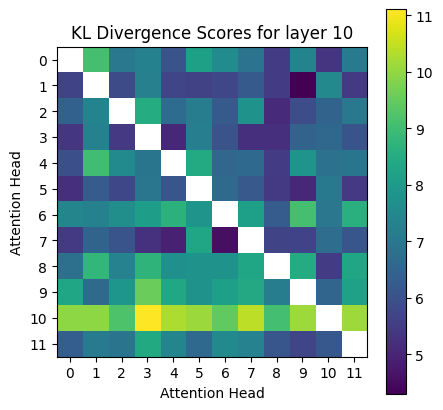

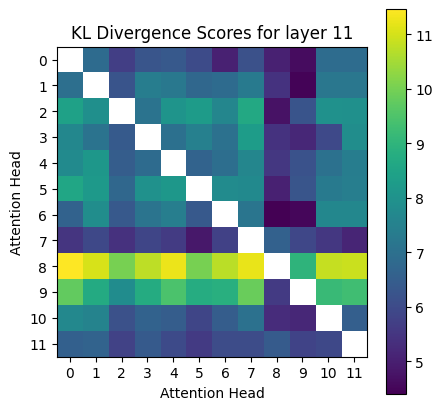

In [13]:
cross_attention_matrix = calculate_kl_divergence_between_heads(attention, regularization_term=1e-6)
plot_kl_divergence_scores_between_heads(cross_attention_matrix)

C:\Users\marti\AppData\Local\Temp\ipykernel_13628\797895484.py:259: RuntimeWarning: divide by zero encountered in log
  plot_matrix_with_matplotlib(np.log(cross_attention_matrix), title="KL Divergence Scores", xlabel="Layer", ylabel="Layer")


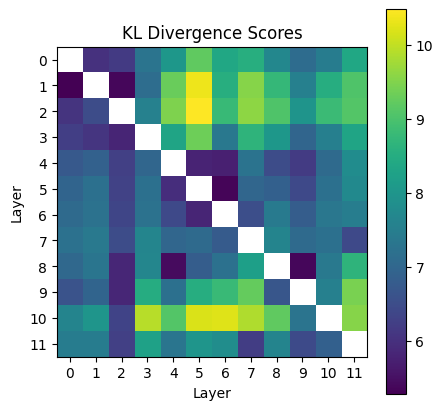

In [14]:

#model_view(attention, tokens, sentence_b_start)

cross_attention_matrix = calculate_kl_divergence_between_layers(attention, regularization_term=1e-9)
plot_kl_divergence_scores_between_layers(cross_attention_matrix)

In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def translation_task(sentence, source_language, target_language):

    # Initialize the model and tokenizer
    model_version = 't5-small'  # Using the 't5-small' model for this example
    model = T5ForConditionalGeneration.from_pretrained(model_version, output_attentions=True)
    tokenizer = T5Tokenizer.from_pretrained(model_version)

    # Prepare the input text
    input_text = f"translate {source_language} to {target_language}: {sentence}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    # Forward pass through the model to get the output and attention
    output_sequences = model.generate(input_ids, output_attentions=True, return_dict_in_generate=True)
    translated_text = tokenizer.decode(output_sequences.sequences[0], skip_special_tokens=True)
    print(translated_text)

    encoder_attention = output_sequences.encoder_attentions  # List of tensors containing attentions from each layer of the encoder
    decoder_attention = output_sequences.decoder_attentions  # List of tensors containing attentions from each layer of the decoder
    cross_attention = output_sequences.cross_attentions  # List of tensors containing cross-attentions from each layer of the decoder

    # Note: For tasks like translation, you might want to directly work with the 'generate' method
    # which encapsulates the model's forward pass and generates the target sequence.
    # The `attention` obtained here corresponds to the attentions of the last decoder layer.

    input_id_list = input_ids[0].tolist() # Batch index 0
    output_id_list = output_sequences[0][0].tolist()
    tokens_input = tokenizer.convert_ids_to_tokens(input_id_list)
    tokens_output = tokenizer.convert_ids_to_tokens(output_id_list)
    tokens_in_out = tokens_input + tokens_output 
    index_sentence_b_start = len(tokens_input)
    #head_view(encoder_attention, tokens_input)

    #plot_mean_attention_layers(encoder_attention)

    def combine_attention_masks(encoder_attention, cross_attention, decoder_attention):
        """
        Combine the attention masks from the encoder, cross-attention, and decoder into a single attention mask.

        Parameters:
        - encoder_attention: A list of tensors containing the attention masks from the encoder.
        - cross_attention: A list of tensors containing the attention masks from the cross-attention.
        - decoder_attention: A list of tensors containing the attention masks from the decoder.

        Returns:
        - combined_attention: A list of tensors containing the combined attention masks.
        """
        num_layers = len(encoder_attention)
        num_attention_heads = encoder_attention[0].size(1)
        encoder_attention_size = encoder_attention[0].size(2) #14
        decoder_attention_size = decoder_attention[-1][0].size(-1) + 1 #12
        combined_size = encoder_attention_size + decoder_attention_size
        combined_attentions = []
        for layer in range(num_layers):
            combined_attention = torch.zeros(1, num_attention_heads, combined_size, combined_size, dtype=torch.float32)
            combined_attention[:, :, :encoder_attention_size, :encoder_attention_size] = encoder_attention[layer]
            for timestep in range(decoder_attention_size - 1):
                combined_attention[:, :, encoder_attention_size + timestep + 1, :encoder_attention_size] = cross_attention[timestep][layer].squeeze(2)
                combined_attention[:, :, encoder_attention_size + timestep + 1, encoder_attention_size:encoder_attention_size+timestep + 1] = decoder_attention[timestep][layer].squeeze(2)
            combined_attentions.append(combined_attention)
            
        return tuple([attn for attn in combined_attentions])

    combined_attention = combine_attention_masks(encoder_attention, cross_attention, decoder_attention)


    #head_view(combined_attention, tokens_in_out, index_sentence_b_start)
    #model_view(combined_attention, tokens_in_out, index_sentence_b_start)
    #lot_mean_attention_layers(combined_attention)
    kl_divergence_matrix = calculate_kl_divergence_between_heads(combined_attention, regularization_term=1e-6)
    plot_kl_divergence_scores_between_heads(kl_divergence_matrix)
    kl_divergence_matrix = calculate_kl_divergence_between_layers(combined_attention, regularization_term=1e-12)
    plot_kl_divergence_scores_between_layers(kl_divergence_matrix)


In [16]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def summarization_task(sentence):
    # Load the tokenizer and model
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    model.config.output_attentions = True  # Ensure we get attention scores

    # Example input text
    text = sentence
    input_text = "summarize: " + text

    # Generate a summary
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids
    summary_ids = model.generate(input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    print("Generated Summary:", summary)

    # Prepare input for getting attention scores, using the generated summary as part of the input
    # Note: This step might not reflect the actual generation process and is for demonstration only
    decoder_input_ids = tokenizer(summary, return_tensors="pt").input_ids
    outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

    encoder_attention = outputs.encoder_attentions  # List of tensors containing attentions from each layer of the encoder
    decoder_attention = outputs.decoder_attentions  # List of tensors containing attentions from each layer of the decoder
    cross_attention = outputs.cross_attentions  # List of tensors containing cross-attentions from each layer of the decoder

    # Note: For tasks like translation, you might want to directly work with the 'generate' method
    # which encapsulates the model's forward pass and generates the target sequence.
    # The `attention` obtained here corresponds to the attentions of the last decoder layer.

    input_id_list = input_ids[0].tolist() # Batch index 0
    output_id_list = summary_ids[0].tolist()
    tokens_input = tokenizer.convert_ids_to_tokens(input_id_list)
    tokens_output = tokenizer.convert_ids_to_tokens(output_id_list)
    tokens_in_out = tokens_input + tokens_output 
    index_sentence_b_start = len(tokens_input)
    #head_view(encoder_attention, tokens_input)

    def combine_attention_masks(encoder_attention, cross_attention, decoder_attention):
        """
        Combine the attention masks from the encoder, cross-attention, and decoder into a single attention mask.

        Parameters:
        - encoder_attention: A list of tensors containing the attention masks from the encoder.
        - cross_attention: A list of tensors containing the attention masks from the cross-attention.
        - decoder_attention: A list of tensors containing the attention masks from the decoder.

        Returns:
        - combined_attention: A list of tensors containing the combined attention masks.
        """
        num_layers = len(encoder_attention)
        num_attention_heads = encoder_attention[0].size(1)
        encoder_attention_size = encoder_attention[0].size(2) 
        decoder_attention_size = decoder_attention[0].size(2) + 1
        combined_size = encoder_attention_size + decoder_attention_size
        combined_attentions = []
        for layer in range(num_layers):
            combined_attention = torch.zeros(1, num_attention_heads, combined_size, combined_size, dtype=torch.float32)
            combined_attention[:, :, :encoder_attention_size, :encoder_attention_size] = encoder_attention[layer]
            combined_attention[:, :, encoder_attention_size + 1:, :encoder_attention_size] = cross_attention[layer]
            combined_attention[:, :, encoder_attention_size+1:, encoder_attention_size:combined_size-1] = decoder_attention[layer]
            combined_attentions.append(combined_attention)
            
        return tuple([attn for attn in combined_attentions])

    combined_attention = combine_attention_masks(encoder_attention, cross_attention, decoder_attention)

    head_view(combined_attention, tokens_in_out, index_sentence_b_start)
    #model_view(combined_attention, tokens_in_out, index_sentence_b_start)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Eine Katze hat die Straße überschritten.


C:\Users\marti\AppData\Local\Temp\ipykernel_13628\797895484.py:256: RuntimeWarning: divide by zero encountered in log
  plot_matrix_with_matplotlib(np.log(cross_attention_matrix[i]), title=f"KL Divergence Scores for layer {i}", xlabel="Attention Head", ylabel="Attention Head")


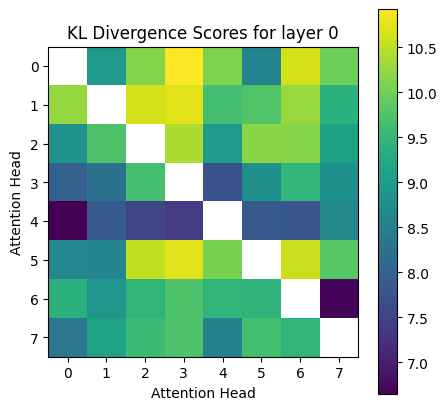

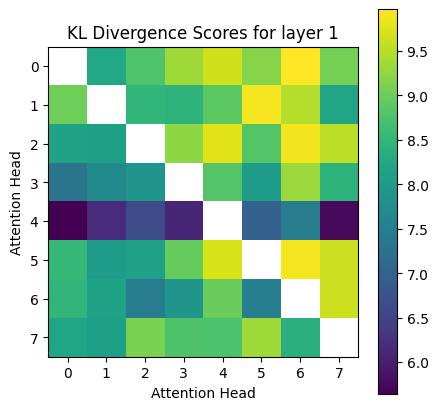

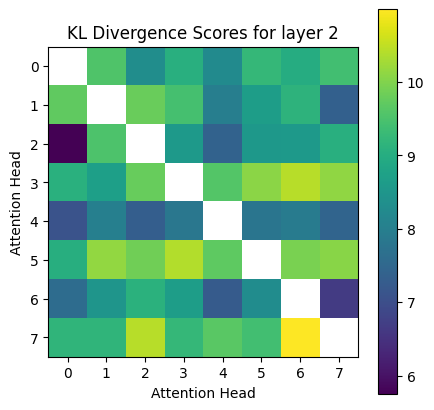

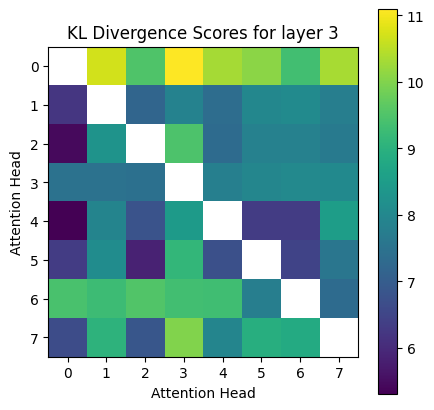

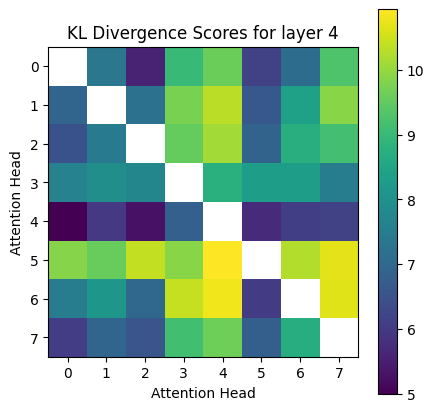

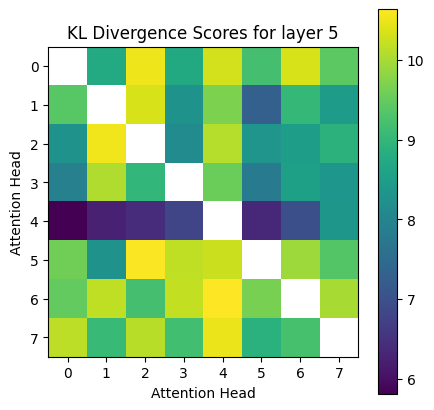

C:\Users\marti\AppData\Local\Temp\ipykernel_13628\797895484.py:259: RuntimeWarning: divide by zero encountered in log
  plot_matrix_with_matplotlib(np.log(cross_attention_matrix), title="KL Divergence Scores", xlabel="Layer", ylabel="Layer")


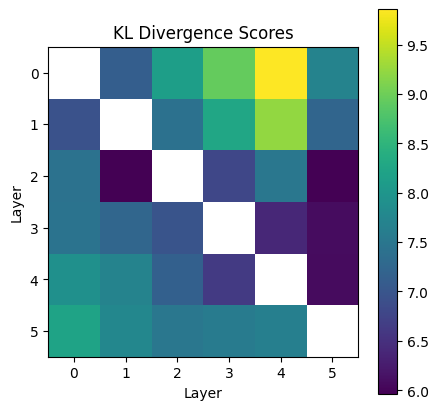

In [17]:
translation_task("A cat went over the street.", "English", "German") #"Nous couttons ton argent de poche."
#summarization_task("""The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing global pandemic of coronavirus disease 2019 (COVID-19), caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2).""")

In [18]:
from PIL import Image
import requests

def resize_and_crop_image(image, output_size=(384, 384)):
    """
    Resize the shorter side of the image to the target size while maintaining aspect ratio,
    and then crop the center square of the specified size.

    Parameters:
    - image_ (str): image to transform.
    - output_size (tuple of int): The target size of the output image (width, height).

    Returns:
    - PIL.Image: The transformed image.
    """
    
    # Resize the image so the shorter side matches the target size
    img_aspect_ratio = image.width / image.height
    target_aspect_ratio = output_size[0] / output_size[1]
    
    if img_aspect_ratio > target_aspect_ratio:
        # If image is wider than the target aspect ratio, scale by height
        new_height = output_size[1]
        new_width = int(new_height * img_aspect_ratio)
    else:
        # If image is taller than the target aspect ratio, scale by width
        new_width = output_size[0]
        new_height = int(new_width / img_aspect_ratio)
    
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Crop the center
    left = (new_width - output_size[0]) / 2
    top = (new_height - output_size[1]) / 2
    right = (new_width + output_size[0]) / 2
    bottom = (new_height + output_size[1]) / 2
    
    image = image.crop((left, top, right, bottom))
    
    return image

def visualize_image_patches(image, patch_size=(32, 32), image_size=(384, 384)):
    """
    Visualize the patches of an image in a grid.

    Parameters:
    - image (str): image to transform and visualize.
    - patch_size (tuple of int): The size of each patch (width, height).
    - image_size (tuple of int): The target size of the image (width, height) before patching.
    """

    # Calculate the number of patches along width and height
    patches_x = image_size[0] // patch_size[0]
    patches_y = image_size[1] // patch_size[1]

    # Create a figure to visualize the patches
    fig, axs = plt.subplots(patches_y, patches_x, figsize=(8, 8))
    
    for i in range(patches_y):
        for j in range(patches_x):
            # Calculate the coordinates of the current patch
            x0 = j * patch_size[0]
            y0 = i * patch_size[1]
            x1 = x0 + patch_size[0]
            y1 = y0 + patch_size[1]

            # Extract the patch and plot it
            patch = image.crop((x0, y0, x1, y1))
            axs[i, j].imshow(patch)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Prediction is brown bear with probability 0.9984155893325806


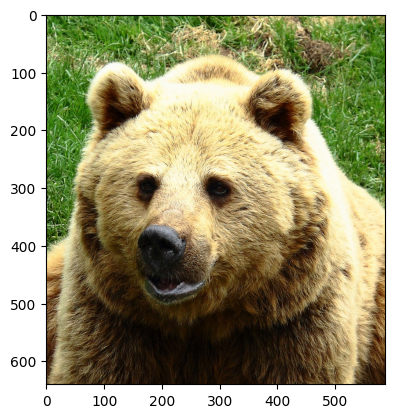

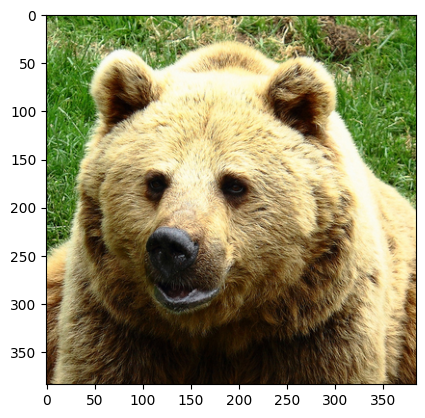

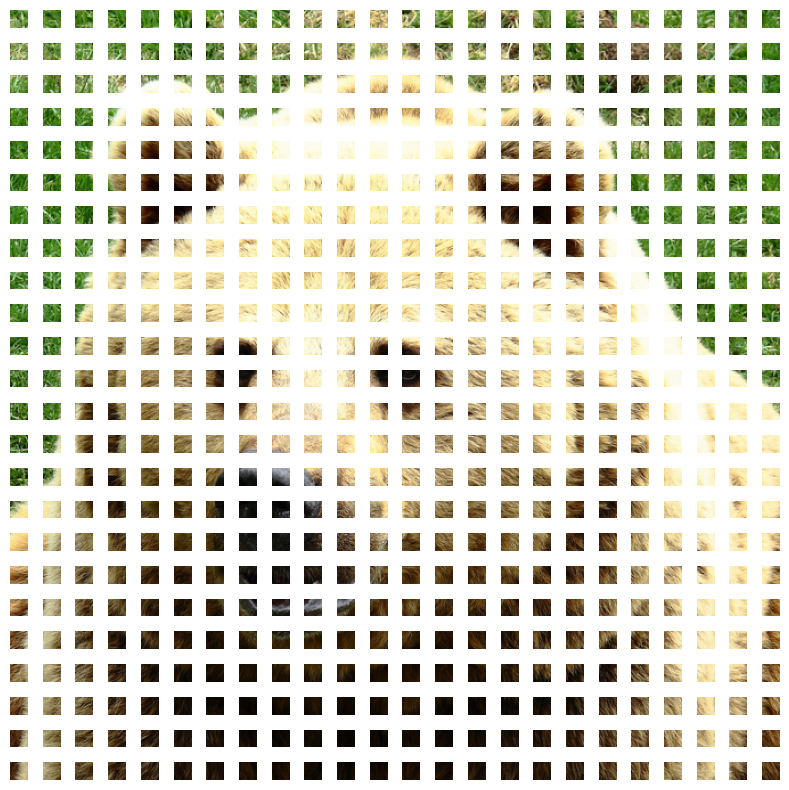

torch.Size([1, 12, 577, 577])


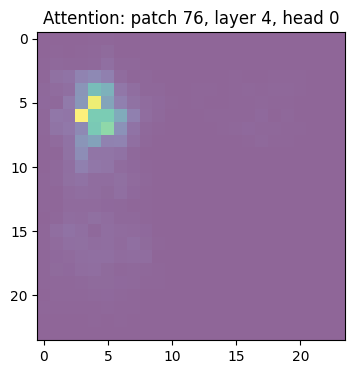

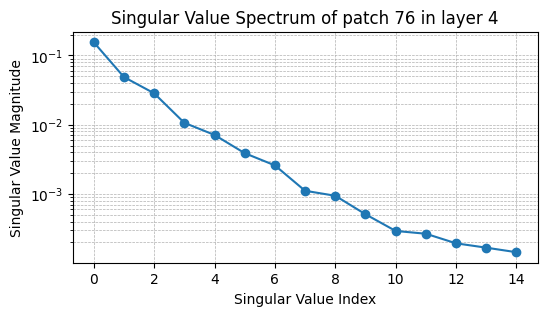

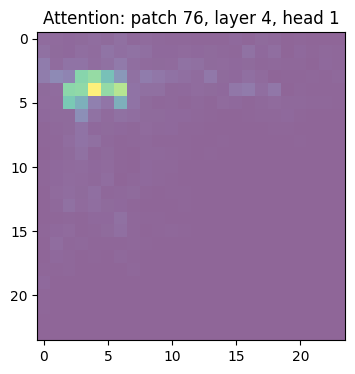

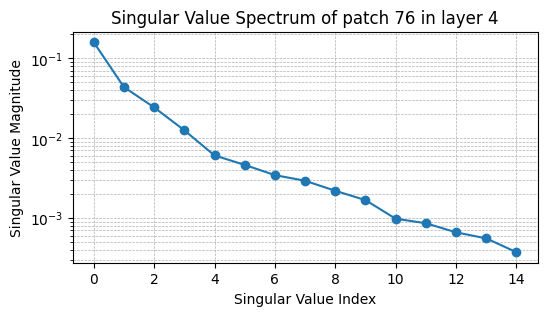

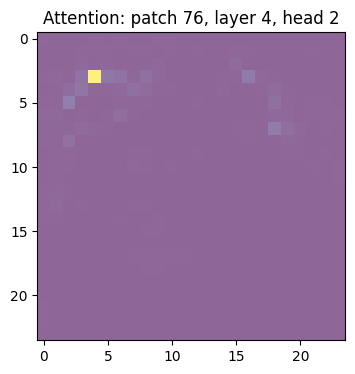

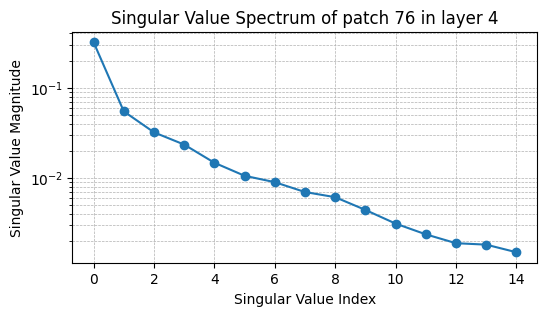

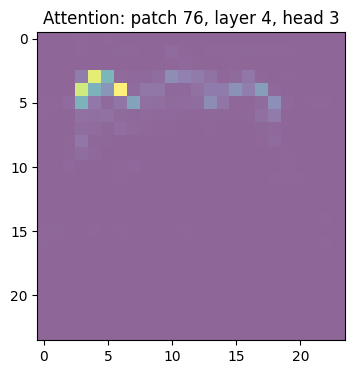

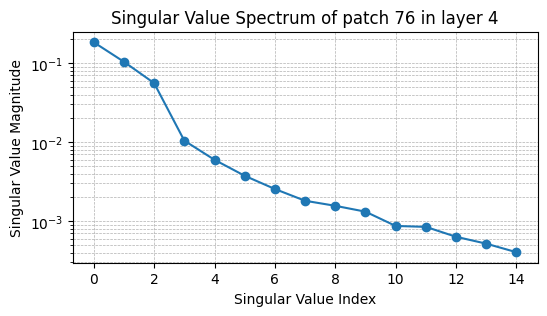

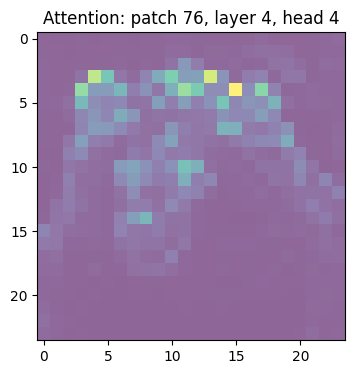

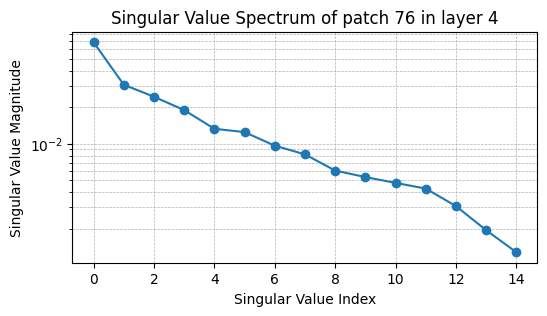

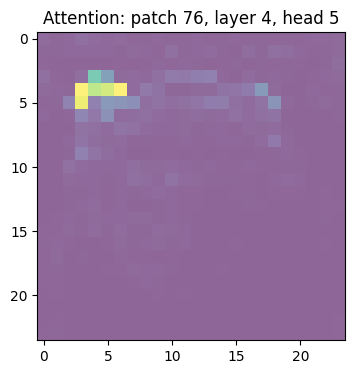

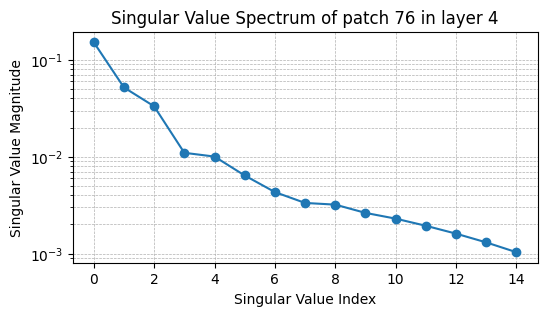

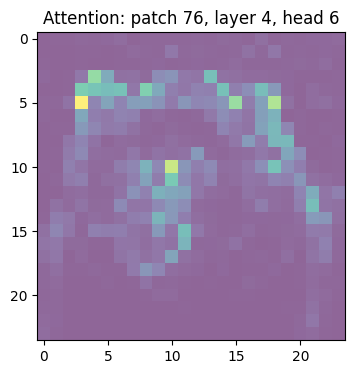

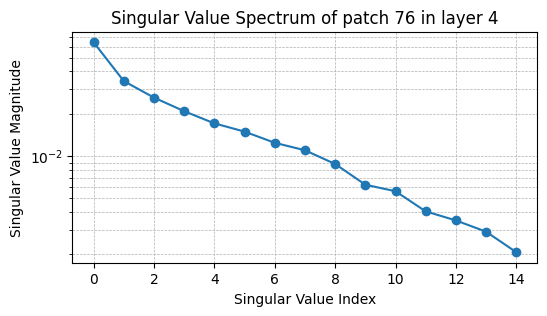

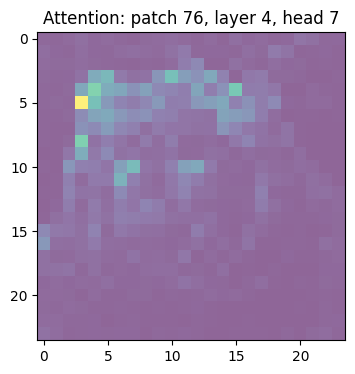

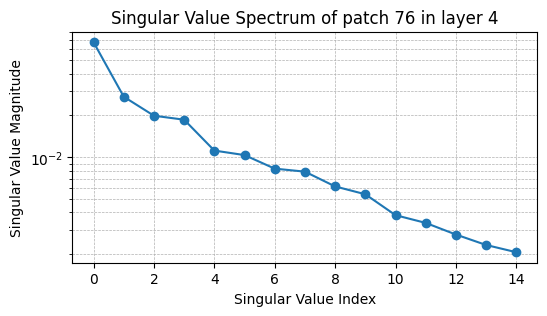

In [29]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch

# Initialize the feature extractor and model
model_name = 'google/vit-base-patch16-224-in21k'
model_name = 'google/vit-base-patch16-384'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

# Load and preprocess an image
image_url = 'http://images.cocodataset.org/val2017/000000000285.jpg' #cat=000000039769 #bear=000000000285
image = Image.open(requests.get(image_url, stream=True).raw)
plt.imshow(image)
plt.figure()
cropped_image = resize_and_crop_image(image)
plt.imshow(cropped_image)

def get_imagenet_label(class_id, labels_file='imagenet-simple-labels.json'):
    import json
    # Load labels from a file
    with open(labels_file) as f:
        labels_map = json.load(f)
    
    # Convert class_id to string since JSON keys are stored as strings
    class_id_str = str(labels_map[class_id])
    
    # Return the corresponding class name or a default if not found
    return class_id_str


inputs = feature_extractor(images=image, return_tensors="pt")

normal_outputs = model(**inputs)
# Forward pass to get the output and attention weights
outputs = model(**inputs, output_attentions=True)

#get attention scores
attention = outputs.attentions
# Convert logits to probabilities
probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get the top 5 predicted classes and their probabilities
top5_prob, top5_catid = torch.topk(probabilities, 5)
candid_list = top5_catid[0].detach().numpy()
top5_labels = [get_imagenet_label(id) for id in candid_list]
print(f"Prediction is {top5_labels[0]} with probability {top5_prob[0][0].detach().numpy()}")

visualize_image_patches(cropped_image, patch_size=(16, 16))
print(attention[-1].size())

def plot_mean_attention_layers(attention):
    for layer in range(len(attention)):
        plt.figure(figsize=(4, 4))
        plt.imshow(np.log(torch.mean(attention[layer][0], dim=0).detach().numpy() + 1), cmap='viridis', aspect='equal', alpha=0.6)
        plt.title('Mean attention weights of layer {}'.format(layer))
        plt.show()

# `attention_weights` is a tuple where each element corresponds to the attention
# weights from one of the transformer blocks.
    
#cross_attention_matrix = calculate_cross_entropy_between_heads(attention)

def plot_patch_attenion(attention, patch_id_x, patch_id_y, layer_id, head_id=-1):
    plt.figure(figsize=(4, 4)) 
    if head_id == -1:
        head_attention = tuple([torch.mean(attention[layer][0], dim=0) for layer in range(model.config.num_hidden_layers)])
    else:
        head_attention = tuple([attention[layer][0][head_id] for layer in range(model.config.num_hidden_layers)])
    dim = np.sqrt(head_attention[layer_id].size(1) - 1).astype(int)
    patch_id = patch_id_y * dim + patch_id_x
    reshaped_image = torch.reshape(head_attention[layer_id][patch_id + 1][1:], (dim, dim))
    plt.imshow(reshaped_image.detach().numpy(), cmap='viridis', aspect='equal', alpha=0.6)
    plt.title(f'Attention: patch {patch_id}, layer {layer_id}, head {head_id}')
    plt.show()
    _, S, _ = perform_svd(reshaped_image.detach().numpy())
    plot_singular_value_spectrum(S[:15], title=f"Singular Value Spectrum of patch {patch_id} in layer {layer_id}")

#for i in range(5):
 #   plot_patch_attenion(attention, patch_id_x=10, patch_id_y=4, layer_id=i)
#for i in range(5):
  #  plot_patch_attenion(attention, patch_id_x=7, patch_id_y=14, layer_id=i)
#for i in range(5):
 #   plot_patch_attenion(attention, patch_id_x=4, patch_id_y=3, layer_id=i)
for j in range(8):
    plot_patch_attenion(attention, patch_id_x=4, patch_id_y=3, layer_id=4, head_id=j)
#plot_mean_attention_layers(attention)
#plot_all_cross_entropy_scores(cross_attention_matrix)

In [20]:
from transformers import AutoTokenizer, LxmertForQuestionAnswering, LxmertTokenizer
import requests
from PIL import Image
import torch

# Initialize the model and tokenizer
model_name = 'unc-nlp/lxmert-base-uncased'
tokenizer = LxmertTokenizer.from_pretrained(model_name)
model = LxmertForQuestionAnswering.from_pretrained(model_name, output_attentions=True, output_hidden_states=True)

# Example question and URL to an image
question = "Wht type of fruit is on the image?"
image_url = "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg" # Use an actual image URL

# Load the image from the web
image = Image.open(requests.get(image_url, stream=True).raw)
#plt.imshow(image)

# Preprocess and encode text and image for the model
inputs = tokenizer(question, return_tensors='pt')
input_ids = inputs.input_ids
outputs = model(input_ids=input_ids, 
                visual_feats=torch.rand(1, 36, 2048), # Simulated features, replace with actual
                visual_pos=torch.rand(1, 36, 4), # Simulated bounding boxes, replace with actual
                output_attentions=True)

# The output logits are in outputs.question_answering_score
answer_logits = outputs.question_answering_score

# Convert logits to probabilities (optional)
answer_probs = torch.softmax(answer_logits, dim=1)

# Find the highest probability answer
max_prob, answer_idx = torch.max(answer_probs, dim=1)
answer = tokenizer.decode(answer_idx)

#print(f"Predicted answer: {answer}")

# Extract attention weights
language_attentions = outputs.language_attentions
vision_attentions = outputs.vision_attentions
cross_encoder_attentions = outputs.cross_encoder_attentions
language_hidden_states = outputs.language_hidden_states
vision_hidden_states = outputs.vision_hidden_states
#print(language_attentions[-1].size())
#print(vision_attentions[-1].size())
#print(cross_encoder_attentions[-1].size())


Question: What are the cats doing?
Predicted answer: sleeping
torch.Size([1, 12, 200, 200])
torch.Size([1, 12, 200, 200])
208


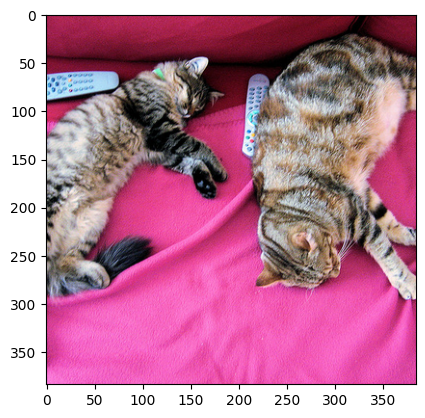

In [21]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# prepare image + question

question = "What type of fruit is in the image?"
url = "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg"

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
question = "What are the cats doing?"

image = Image.open(requests.get(url, stream=True).raw)
cropped_image = resize_and_crop_image(image)
plt.imshow(cropped_image)
#visualize_image_patches(cropped_image, patch_size=(32, 32))

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor(image, question, return_tensors="pt")

# forward pass
outputs = model(**encoding, output_attentions=True)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Question:", question)
print("Predicted answer:", model.config.id2label[idx])

input_ids = encoding["input_ids"]
len_input = len(input_ids[0])
attention =outputs.attentions

attention1 = attention[0][:, :, 1:, 1:]
attention2 = attention[1][:, :, 1:, 1:]
print(attention1.size())
print(attention2.size())
print(12*12+8*8)


In [27]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

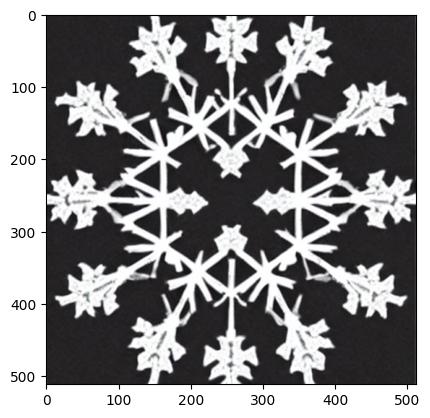

In [28]:
prompt = "a snowflake in the shape of a math fractal"
image = pipe(prompt).images[0]
plt.imshow(image)

In [25]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

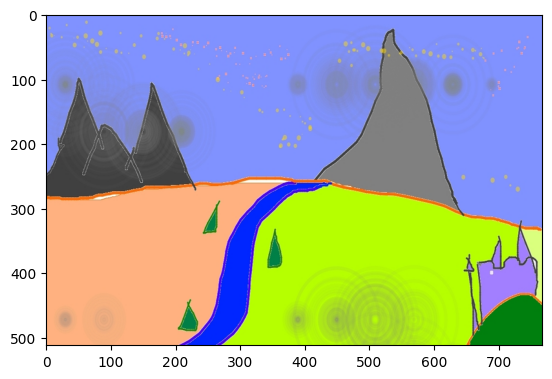

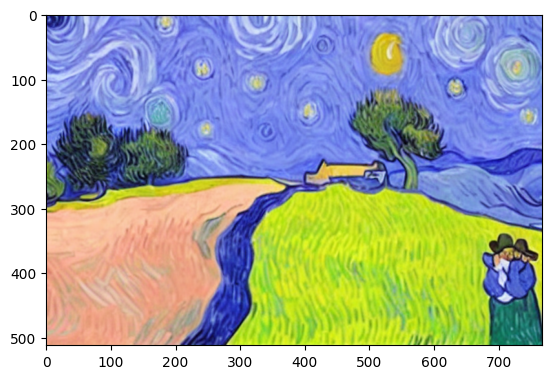

In [26]:
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "Van Gogh artstyle"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
resulting_image = images[0]
plt.imshow(init_image)
plt.figure()
plt.imshow(resulting_image)